In [2]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Define Signals

## Basic stuff

In [102]:
# sample period 
dt = 2e-9 # 2ns <-> 500 MHz

# length of signal 2 relative to signal 1
length_factor = 2

# number of samples
num_samp1 = 8192
num_samp2 = length_factor * num_samp1

# time
time1 = np.arange(0, num_samp1, 1) * dt
time2 = np.arange(0, num_samp2, 1) * dt

# signal power
power = 1

# noise_variance
noise_variance = 1e2

## Signal 1 and Signal 2

Energy signal 1 = 8192.0
Energy signal 2 = 8192.0
Power signal 1 = 1.0
Power signal 2 = 0.5


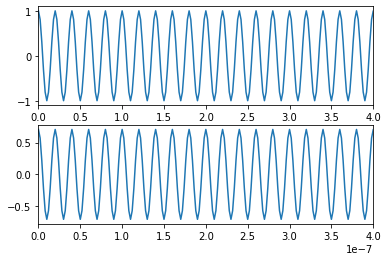

In [137]:
## signal 1

# amplitude signal 1
amp1 = np.sqrt(power)

# frequency signal 1
#freq1 = 66.8945e6 # uncomment to use frequency exactly on a DFFT frequency.
freq1 = 50e6

s1 = amp1 * np.exp(-1j * 2 * np.pi * freq1 * time1) 

## signal 2

# amplitude signal 2
amp2 = np.sqrt(power / length_factor)

# frequency signal 2
freq2 = freq1

s2 = amp2 * np.exp(-1j * 2 * np.pi * freq2 * time2)

fig = plt.figure()

ax1 = plt.subplot(2, 1, 1)
ax1.plot(time1, np.real(s1))
ax1.set_xlim(time1[0], time1[200])

ax2 = plt.subplot(2, 1, 2)
ax2.plot(time2, np.real(s2))
ax2.set_xlim(time2[0], time2[200])

print('Energy signal 1 = %.1f' % (np.vdot(s1, s1).real))
print('Energy signal 2 = %.1f' % (np.vdot(s2, s2).real))

print('Power signal 1 = %.1f' % (np.vdot(s1, s1).real / num_samp1))
print('Power signal 2 = %.1f' % (np.vdot(s2, s2).real / num_samp2))

## noisy signal1 and signal 2

(0.0, 4.0000000000000003e-07)

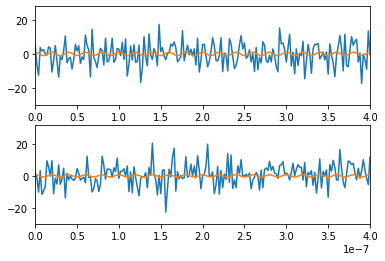

In [138]:
# signal 1
noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, int(np.ceil(num_samp1)))
noise = noise[:, 0] + 1j * noise[:, 1]

x1 = s1 + noise

# signal 2
noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, int(np.ceil(num_samp2)))
noise = noise[:, 0] + 1j * noise[:, 1]

x2 = s2 + noise

fig = plt.figure()

ax1 = plt.subplot(2, 1, 1)
ax1.plot(time1, np.real(x1))
ax1.plot(time1, np.real(s1))
ax1.set_xlim(time1[0], time1[200])

ax2 = plt.subplot(2, 1, 2)
ax2.plot(time2, np.real(x2))
ax2.plot(time2, np.real(s2))
ax2.set_xlim(time2[0], time2[200])


# Baseline - FFT

Power signal 1 = 1.0
Power signal 2 = 0.5
Mean SNR for signal 1 = 74.88
Mean SNR for signal 2 = 59.06

Note FFT SNR is not equal due to discrete frequency effects.


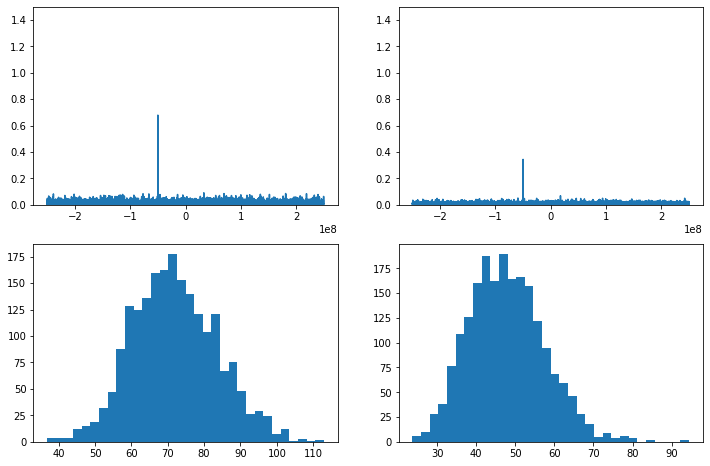

In [141]:
# transform
fft1 = np.fft.fftshift(np.fft.fft(x1)) / num_samp1
fft2 = np.fft.fftshift(np.fft.fft(x2)) / num_samp2

freq1 = np.fft.fftshift(np.fft.fftfreq(int(np.ceil(num_samp1)), dt))
freq2 = np.fft.fftshift(np.fft.fftfreq(int(np.ceil(num_samp2)), dt))

fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(freq1, abs(fft1)**2)
ax1.set_ylim(0, 1.5)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(freq2, abs(fft2)**2)
ax2.set_ylim(0, 1.5)

# get stats
N = 2048

snr_list1 = []
snr_list2 = []
for n in range(N):
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, int(np.ceil(num_samp1)))
    noise = noise[:, 0] + 1j * noise[:, 1]

    x1 = s1 + noise

    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, int(np.ceil(num_samp2)))
    noise = noise[:, 0] + 1j * noise[:, 1]

    x2 = s2 + noise
    
    fft1 = np.fft.fftshift(np.fft.fft(x1)) / num_samp1
    fft2 = np.fft.fftshift(np.fft.fft(x2)) / num_samp2
    
    snr_list1.append(np.max(abs(fft1))**2 / np.mean(abs(fft1)**2))
    snr_list2.append(np.max(abs(fft2))**2 / np.mean(abs(fft2)**2))

#print(np.max(abs(fft1)**2), np.max(abs(fft2))**2)
print('Power signal 1 = %.1f' % (np.vdot(s1, s1).real / num_samp1))
print('Power signal 2 = %.1f' % (np.vdot(s2, s2).real / num_samp2))


ax3 = plt.subplot(2, 2, 3)
hist1 = ax3.hist(snr_list1, 32)
#ax3.set_ylim(0, 1.5)

ax4 = plt.subplot(2, 2, 4)
hist2 = ax4.hist(snr_list2, 32)

print('Mean SNR for signal 1 = %.2f' % np.mean(hist1[1]))
print('Mean SNR for signal 2 = %.2f' % np.mean(hist2[1]))
print('\nNote FFT SNR is not equal due to discrete frequency effects.')

# Matched Filter

Power signal 1 = 1.0
Power signal 2 = 0.5
Mean MF score for signal 1 = 9.17
Mean SNR for signal 2 = 9.24


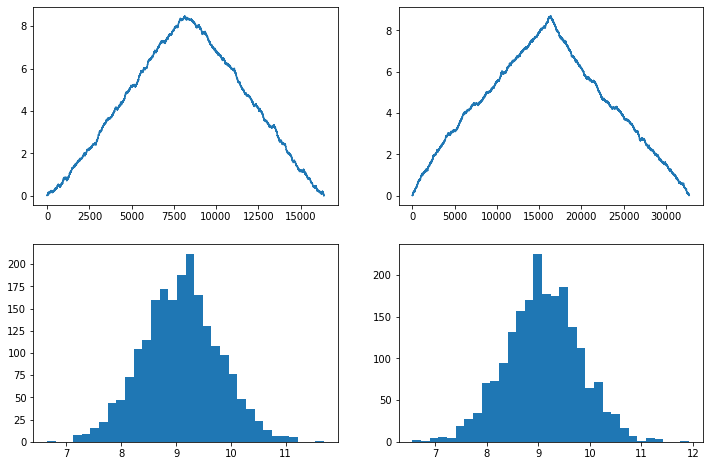

In [140]:
# templates
h1 = s1 / (np.sqrt(np.vdot(s1, s1).real * noise_variance))
h2 = s2 / (np.sqrt(np.vdot(s2, s2).real * noise_variance))

# convolve
conv1 = scipy.signal.fftconvolve(h1, x1)
conv2 = scipy.signal.fftconvolve(h2, x2)

fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(abs(conv1))
#ax1.set_xlim(num_samp1 * 0.9, num_samp1 * 1.1)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(abs(conv2))
#ax2.set_ylim(0, 1.5)

# get stats
N = 2048

mf_score_list1 = []
mf_score_list2 = []
for n in range(N):
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, int(np.ceil(num_samp1)))
    noise = noise[:, 0] + 1j * noise[:, 1]

    x1 = s1 + noise

    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, int(np.ceil(num_samp2)))
    noise = noise[:, 0] + 1j * noise[:, 1]

    x2 = s2 + noise
    
    mf_score_list1.append(np.vdot(h1, x1))
    mf_score_list2.append(np.vdot(h2, x2))

#print(np.max(abs(fft1)**2), np.max(abs(fft2))**2)
print('Power signal 1 = %.1f' % (np.vdot(s1, s1).real / num_samp1))
print('Power signal 2 = %.1f' % (np.vdot(s2, s2).real / num_samp2))


ax3 = plt.subplot(2, 2, 3)
hist1 = ax3.hist(abs(np.asarray(mf_score_list1)), 32)
#ax3.set_ylim(0, 1.5)

ax4 = plt.subplot(2, 2, 4)
hist2 = ax4.hist(abs(np.asarray(mf_score_list2)), 32)

print('Mean MF score for signal 1 = %.2f' % np.mean(hist1[1]))
print('Mean SNR for signal 2 = %.2f' % np.mean(hist2[1]))
print('\nMF filter scores are the same for signals with the same energy but different lengths.')